# End-to-end learning for music audio

- http://qiita.com/himono/items/a94969e35fa8d71f876c

```
# データのダウンロード
wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.001
wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.002
wget http://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.003

# 結合
cat data/mp3.zip.* > data/music.zip

# 解凍
unzip data/music.zip -d music
```

In [45]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

## MP3ファイルのロード

In [4]:
import numpy as np
from pydub import AudioSegment

def mp3_to_array(file):
    # MP3 => RAW
    song = AudioSegment.from_mp3(file)
    song_arr = np.fromstring(song._data, np.int16)
    return song_arr

In [5]:
%ls data/music/1/ambient_teknology-phoenix-01-ambient_teknology-0-29.mp3

data/music/1/ambient_teknology-phoenix-01-ambient_teknology-0-29.mp3


In [8]:
file = 'data/music/1/ambient_teknology-phoenix-01-ambient_teknology-0-29.mp3'
song = mp3_to_array(file)

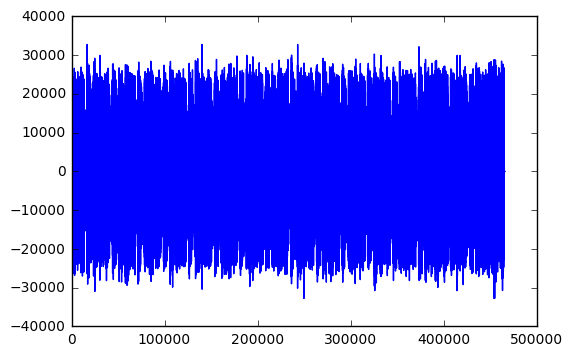

In [11]:
plt.plot(song)

## 楽曲タグデータをロード

- ランダムに3000曲を抽出
- よく使われるタグ50個を抽出
- 各曲には複数のタグがついている

In [18]:
import pandas as pd

tags_df = pd.read_csv('data/annotations_final.csv', delim_whitespace=True)
# 全体をランダムにサンプリング
tags_df = tags_df.sample(frac=1)
# 最初の3000曲を使う
tags_df = tags_df[:3000]

tags_df

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
4929,10810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7/dac_crowell-the_sea_and_the_sky-02-umi_no_ka...
10062,22053,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/mijo-fata_morgana-05-deep_bass_9-0-29.mp3
19365,42594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6/ed_martin-luis_milan__el_maestro-10-fantasia...
17077,37483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/ensemble_mirable-conversations_galantes-08-s...
6236,13612,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,e/magnatune_com-magnatune_at_the_cc_salon-03-l...
13796,30258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4/tilopa-kyotaku_live-07-ajikan-204-233.mp3
24429,54483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b/jacob_heringman-jane_pickeringes_lute_book-1...
8722,19083,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/satori-healing_sounds_of_tibet-04-pray-59-88...
10914,23976,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3/american_baroque-mozart_4_quartets_for_strin...
21173,46514,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d/daniel_ben_pienaar-book_2_cd1_welltempered_c...


In [34]:
top50_tags = tags_df.iloc[:, 1:189].sum().sort_values(ascending=False).index[:50].tolist()
y = tags_df[top50_tags].values
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 楽曲データをロード

- tags_dfのmp3_pathからファイルパスを取得
- mp3_to_array()でnumpy arrayをロード
- (samples, features, channels) になるようにreshape
- 音声波形は1次元なのでchannelsは1
- 訓練データはすべて同じサイズなのでfeaturesは同じになるはず（パディング不要）

In [48]:
files = tags_df.mp3_path.values
files = [os.path.join('data', 'music', x) for x in files]

In [49]:
X = np.array([mp3_to_array(file) for file in files])
X = X.reshape(X.shape[0], X.shape[1], 1)

In [50]:
X.shape

(3000, 465984, 1)

## 訓練データとテストデータに分割

In [51]:
from sklearn.model_selection import train_test_split
random_state = 42

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [59]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2400, 465984, 1)
(600, 465984, 1)
(2400, 50)
(600, 50)


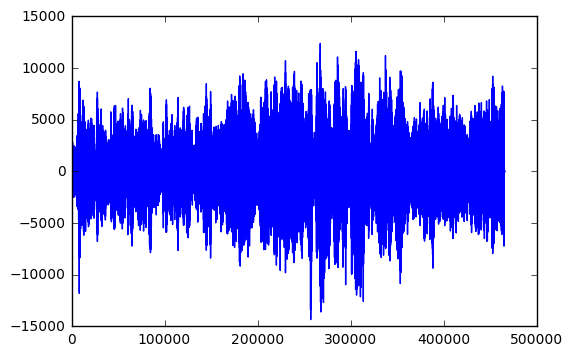

In [61]:
plt.plot(train_x[0])

In [56]:
np.save('train_x.npy', train_x)
np.save('test_x.npy', test_x)
np.save('train_y.npy', train_y)
np.save('test_y.npy', test_y)

## 訓練

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D
from keras.callbacks import CSVLogger, ModelCheckpoint

train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')

test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

features = train_x.shape[1]

x_inputs = Input(shape=(features, 1), name='x_inputs')
x = Conv1D(128, 256, strides=256, padding='valid', activation='relu')(x_inputs)  # strided conv
x = Conv1D(32, 8, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(32, 8, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(32, 8, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(32, 8, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x_outputs = Dense(50, activation='sigmoid', name='x_outputs')(x)

model = Model(inputs=x_inputs, outputs=x_outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy')

logger = CSVLogger('history.log')
checkpoint = ModelCheckpoint(
    'model.{epoch:02d}-{val_loss:.3f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto')

model.fit(train_x, train_y, batch_size=600, epochs=50,
          validation_data=[test_x, test_y],
          callbacks=[logger, checkpoint])

## 予測

- taggerは複数のタグを出力するのでevaluate()ではダメ？

In [58]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import roc_auc_score

test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

model = load_model('model.22-9.187-0.202.h5')

pred_y = model.predict(test_x, batch_size=50)
print(roc_auc_score(test_y, pred_y))
print(model.evaluate(test_x, test_y))

Using TensorFlow backend.
